In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/datalawyer')
#path_results = Path('/opt/models/elmo/ner/results/')
path_results = Path('/opt/models/elmo/ner/results_datalawyer_jur/')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/opt/models/elmo/ner/results_datalawyer_jur/datalawyer


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    if folder.is_dir():
        results_model_folder = folder.iterdir()
        for training_folder in results_model_folder:
            #print('Reading files from %s' % training_folder.name)
            has_metrics = False
            for results_file in training_folder.iterdir():
                if results_file.name.endswith('.json'):
                    #print('Parsing data from %s' % results_file.name)
                    if results_file.name.startswith('config'):
                        configs[training_folder.name] = json.loads(results_file.read_bytes())
                    elif results_file.name.startswith('metrics.'):
                        metrics[training_folder.name] = json.loads(results_file.read_bytes())
                        has_metrics = True
            if not has_metrics:
                print('metrics.json not found for %s' % training_folder.name)
                metrics[training_folder.name] = None
print(len(metrics))
print(len(configs))

metrics.json not found for datalawyer_wang2vec_cbow_jur_3_0
39
39


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
DOMAN_SPECIFIC = 'Domain_Specific'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, EMBEDDING, DOMAN_SPECIFIC, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Embedding',
 'Domain_Specific',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: False, EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        embedding_type = 'No' if data[1] == 'glove' else data[2]
        domain_specific = data[2] == 'jur'
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: domain_specific, EMBEDDING_TYPE: embedding_type, TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: True, EMBEDDING_TYPE: data[2], TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Invalid id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['datalawyer', 'wang2vec', 'skip', 'jur', '1', '0']
['datalawyer', 'fasttext', 'cbow', 'jur', '0', '0']
['datalawyer', 'wang2vec', 'skip', 'jur', '0', '0']
['datalawyer', 'fasttext', 'skip', 'jur', '2', '0']
['datalawyer', 'word2vec', 'skip', 'jur', '2', '0']
['datalawyer', 'fasttext', 'skip', 'jur', '1', '0']
['datalawyer', 'fasttext', 'cbow', 'jur', '2', '0']
['datalawyer', 'glove-no-elmo', '0', '0']
['datalawyer', 'wang2vec', 'cbow', 'jur', '3', '0']
['datalawyer', 'none', '2', '0']
['datalawyer', 'fasttext', 'skip', '0', '0']
['datalawyer', 'wang2vec', 'cbow', 'jur', '2', '0']
['datalawyer', 'cnn-no-elmo', '0', '0']
['datalawyer', 'word2vec', 'cbow', 'jur', '0', '0']
['datalawyer', 'word2vec', 'cbow', 'jur', '1', '0']
['datalawyer', 'fasttext', 'skip', 'jur', '3', '0']
['datalawyer', 'word2vec', 'cbow', 'jur', '3', '0']
['datalawyer', 'word2vec', 'skip', 'jur', '3', '0']
['datalawyer', 'glove', 'jur', '0', '0']
['datalawyer', 'glove', 'jur', '1', '0']
['datalawyer', 'fasttext', 'cb

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Model,Embedding,Domain_Specific,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,datalawyer_wang2vec_skip_jur_1_0,datalawyer,wang2vec,True,skip,1,0,11.0,20.0,01:22:46,4966.0,248.30,0.996331,0.996492,0.958000,0.957061,0.957530,6.097112,0.987959,0.988311,0.886450,0.881777,0.884107,32.135756,0.985003,0.985601,0.847589,0.854232,0.850898,41.380294
1,datalawyer_fasttext_cbow_jur_0_0,datalawyer,fasttext,True,cbow,0,0,14.0,20.0,01:22:34,4954.0,247.70,0.992319,0.992708,0.917529,0.911837,0.914674,11.156613,0.988625,0.989069,0.879412,0.900602,0.889881,22.052143,0.986024,0.986587,0.845455,0.874608,0.859784,30.901843
2,datalawyer_wang2vec_skip_jur_0_0,datalawyer,wang2vec,True,skip,0,0,10.0,20.0,01:18:50,4730.0,236.50,0.996089,0.996258,0.958265,0.955918,0.957090,6.304842,0.987405,0.987700,0.878338,0.891566,0.884903,31.122399,0.986816,0.987361,0.843465,0.869906,0.856481,38.225307
3,datalawyer_fasttext_skip_jur_2_0,datalawyer,fasttext,True,skip,2,0,11.0,20.0,01:22:23,4943.0,247.15,0.996127,0.996323,0.955131,0.955755,0.955443,6.146752,0.988237,0.988681,0.889650,0.880271,0.884936,31.591052,0.984985,0.985566,0.862589,0.851097,0.856805,43.570426
4,datalawyer_word2vec_skip_jur_2_0,datalawyer,word2vec,True,skip,2,0,17.0,20.0,01:19:57,4797.0,239.85,0.996131,0.996296,0.957304,0.955429,0.956365,6.264353,0.987996,0.988533,0.889811,0.887801,0.888805,33.594122,0.986112,0.986728,0.853033,0.859718,0.856362,45.152010
5,datalawyer_fasttext_skip_jur_1_0,datalawyer,fasttext,True,skip,1,0,8.0,20.0,01:20:22,4822.0,241.10,0.996273,0.996438,0.956742,0.956898,0.956820,6.263696,0.988274,0.988533,0.885971,0.889307,0.887636,27.520518,0.986904,0.987361,0.855385,0.871473,0.863354,36.415931
6,datalawyer_fasttext_cbow_jur_2_0,datalawyer,fasttext,True,cbow,2,0,17.0,20.0,01:21:59,4919.0,245.95,0.991609,0.991978,0.915271,0.910041,0.912648,11.527814,0.988588,0.988792,0.866762,0.911145,0.888399,22.213076,0.986094,0.986481,0.827535,0.876176,0.851161,32.149850
7,datalawyer_glove-no-elmo_0_0,datalawyer,glove-no-elmo,False,No,0,0,16.0,20.0,00:18:01,1081.0,54.05,0.992881,0.993328,0.913743,0.914634,0.914188,24.969087,0.969171,0.971122,0.730153,0.730885,0.730519,152.411168,0.969171,0.971122,0.730153,0.730885,0.730519,152.411168
8,datalawyer_wang2vec_cbow_jur_3_0,datalawyer,wang2vec,True,cbow,3,0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,datalawyer_none_2_0,datalawyer,none,False,No,2,0,17.0,20.0,01:18:03,4683.0,234.15,0.995635,0.995808,0.950482,0.949551,0.950016,7.341983,0.988533,0.988940,0.878049,0.894578,0.886236,29.632456,0.986710,0.987221,0.839098,0.874608,0.856485,39.703236


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_datalawyer.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'1:17:39.210526'

In [12]:
training_data_df.groupby([EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding_Type,,,,,,,,
cbow,13.0,0.856787,0.003666,0.851161,0.853640,0.857363,0.859784,0.862150
skip,13.0,0.856675,0.004585,0.849825,0.853147,0.856481,0.859166,0.864400
No,12.0,0.815059,0.107619,0.493801,0.846327,0.851439,0.859554,0.866926


In [13]:
training_data_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,7.0,0.858316,0.007476,0.850038,0.851439,0.858140,0.865115,0.866926
word2vec,10.0,0.857376,0.003829,0.851179,0.856100,0.857475,0.859472,0.864400
fasttext,10.0,0.856427,0.004659,0.849825,0.852799,0.856364,0.859893,0.863354
wang2vec,6.0,0.856163,0.003981,0.850898,0.853952,0.855686,0.858310,0.862150
none,3.0,0.849390,0.006220,0.844874,0.845843,0.846812,0.851648,0.856485
glove-no-elmo,1.0,0.730519,NaN,0.730519,0.730519,0.730519,0.730519,0.730519
cnn-no-elmo,1.0,0.493801,NaN,0.493801,0.493801,0.493801,0.493801,0.493801


In [14]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
glove,No,7.0,0.858316,0.007476,0.850038,0.851439,0.858140,0.865115,0.866926
wang2vec,cbow,3.0,0.858236,0.004296,0.853640,0.856280,0.858920,0.860535,0.862150
word2vec,skip,5.0,0.857943,0.004438,0.852201,0.856362,0.857588,0.859166,0.864400
fasttext,skip,5.0,0.856958,0.005667,0.849825,0.853147,0.856805,0.861660,0.863354
word2vec,cbow,5.0,0.856809,0.003533,0.851179,0.856013,0.857363,0.859574,0.859915
fasttext,cbow,5.0,0.855896,0.004004,0.851161,0.852684,0.855922,0.859784,0.859930
wang2vec,skip,3.0,0.854090,0.002877,0.850898,0.852894,0.854890,0.855686,0.856481
none,No,3.0,0.849390,0.006220,0.844874,0.845843,0.846812,0.851648,0.856485
glove-no-elmo,No,1.0,0.730519,NaN,0.730519,0.730519,0.730519,0.730519,0.730519


In [15]:
training_data_df.groupby([EMBEDDING, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Domain_Specific,,,,,,,,
word2vec,False,2.0,0.860206,0.005931,0.856013,0.858110,0.860206,0.862303,0.864400
glove,False,4.0,0.859694,0.007093,0.850406,0.856206,0.860969,0.864456,0.866432
fasttext,True,8.0,0.857305,0.004847,0.849825,0.854732,0.858295,0.860362,0.863354
word2vec,True,8.0,0.856668,0.003311,0.851179,0.855322,0.857475,0.859268,0.859915
glove,True,3.0,0.856479,0.009129,0.850038,0.851255,0.852472,0.859699,0.866926
wang2vec,True,6.0,0.856163,0.003981,0.850898,0.853952,0.855686,0.858310,0.862150
fasttext,False,2.0,0.852915,0.000328,0.852684,0.852799,0.852915,0.853031,0.853147
none,False,3.0,0.849390,0.006220,0.844874,0.845843,0.846812,0.851648,0.856485
glove-no-elmo,False,1.0,0.730519,NaN,0.730519,0.730519,0.730519,0.730519,0.730519


In [16]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std  \
Embedding     Embedding_Type Domain_Specific                              
word2vec      skip           False              1.0  0.864400       NaN   
glove         No             False              4.0  0.859694  0.007093   
wang2vec      cbow           True               3.0  0.858236  0.004296   
fasttext      skip           True               4.0  0.857911  0.006063   
word2vec      cbow           True               4.0  0.857008  0.004047   
fasttext      cbow           True               4.0  0.856699  0.004132   
glove         No             True               3.0  0.856479  0.009129   
word2vec      skip           True               4.0  0.856329  0.002982   
              cbow           False              1.0  0.856013       NaN   
wang2vec      skip           True               3.0  0.854090  0.002877   
fasttext      skip           False              1.0  0.853147       NaN   
              cbow           False              1.0  0.852684       NaN   
none          No             False              3.0  0.849390  0.006220   
glove-no-elmo No             False              1.0  0.730519       NaN   
cnn-no-elmo   No             False              1.0  0.493801       NaN   

                                                   min       25%       50%  \
Embedding     Embedding_Type Domain_Specific                                 
word2vec      skip           False            0.864400  0.864400  0.864400   
glove         No             False            0.850406  0.856206  0.860969   
wang2vec      cbow           True             0.853640  0.856280  0.858920   
fasttext      skip           True             0.849825  0.855060  0.859232   
word2vec      cbow           True             0.851179  0.855817  0.858469   
fasttext      cbow           True             0.851161  0.854732  0.857853   
glove         No             True             0.850038  0.851255  0.852472   
word2vec      skip           True             0.852201  0.855322  0.856975   
              cbow           False            0.856013  0.856013  0.856013   
wang2vec      skip           True             0.850898  0.852894  0.854890   
fasttext      skip           False            0.853147  0.853147  0.853147   
              cbow           False            0.852684  0.852684  0.852684   
none          No             False            0.844874  0.845843  0.846812   
glove-no-elmo No             False            0.730519  0.730519  0.730519   
cnn-no-elmo   No             False            0.493801  0.493801  0.493801   

                                                   75%       max  
Embedding     Embedding_Type Domain_Specific                      
word2vec      skip           False            0.864400  0.864400  
glove         No             False            0.864456  0.866432  
wang2vec      cbow           True             0.860535  0.862150  
fasttext      skip           True             0.862084  0.863354  
word2vec      cbow           True             0.859660  0.859915  
fasttext      cbow           True             0.859821  0.859930  
glove         No             True             0.859699  0.866926  
word2vec      skip           True             0.857982  0.859166  
              cbow           False            0.856013  0.856013  
wang2vec      skip           True             0.855686  0.856481  
fasttext      skip           False            0.853147  0.853147  
              cbow           False            0.852684  0.852684  
none          No             False            0.851648  0.856485  
glove-no-elmo No             False            0.730519  0.730519  
cnn-no-elmo   No             False            0.493801  0.493801

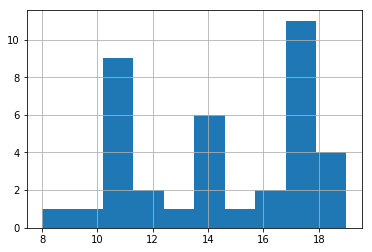

In [17]:
training_data_df[BEST_EPOCH].hist()

In [18]:
training_data_df[TOTAL_DURATION].describe()

count      38.000000
mean     4659.210526
std       854.654890
min      1081.000000
25%      4735.750000
50%      4809.500000
75%      4964.500000
max      5065.000000
Name: Total_Duration(s), dtype: float64

In [19]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
3,5.0,0.859582,0.003185,0.855922,0.857363,0.859166,0.861660,0.863798
2,9.0,0.855516,0.003564,0.851161,0.852472,0.856362,0.856805,0.862150
1,9.0,0.854133,0.005599,0.846812,0.850406,0.852201,0.859915,0.863354
0,15.0,0.824731,0.097389,0.493801,0.851255,0.856481,0.859679,0.866926


In [20]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,38.0,0.843571,0.061966,0.010052,0.823204,0.863939


In [21]:
rp.summary_cont(training_data_df.groupby(MODEL))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Model,,,,,,
datalawyer,38,0.843571,0.061966,0.010052,0.823869,0.863274


In [22]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

/home/user/anaconda3/envs/allennlp/lib/python3.6/site-packages/researchpy/summary.py:151: RuntimeWarning: invalid value encountered in double_scalars
  l_ci = lambda x: numpy.mean(x) - (1.960 * (numpy.std(x)/numpy.sqrt(x.count() - 1)))
/home/user/anaconda3/envs/allennlp/lib/python3.6/site-packages/researchpy/summary.py:154: RuntimeWarning: invalid value encountered in double_scalars
  u_ci = lambda x: numpy.mean(x) + (1.960 * (numpy.std(x)/numpy.sqrt(x.count() - 1)))


,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
cnn-no-elmo,1,0.493801,NaN,NaN,NaN,NaN
fasttext,10,0.856427,0.004659,0.001473,0.853539,0.859315
glove,7,0.858316,0.007476,0.002826,0.852778,0.863854
glove-no-elmo,1,0.730519,NaN,NaN,NaN,NaN
none,3,0.849390,0.006220,0.003591,0.842352,0.856429
wang2vec,6,0.856163,0.003981,0.001625,0.852977,0.859349
word2vec,10,0.857376,0.003829,0.001211,0.855003,0.859749


In [23]:
rp.summary_cont(training_data_df.groupby([MODEL,EMBEDDING]))[TEST_F1_MEASURE]

N      Mean        SD        SE  95% Conf.  \
Model      Embedding                                                    
datalawyer cnn-no-elmo     1  0.493801       NaN       NaN        NaN   
           fasttext       10  0.856427  0.004659  0.001473   0.853539   
           glove           7  0.858316  0.007476  0.002826   0.852778   
           glove-no-elmo   1  0.730519       NaN       NaN        NaN   
           none            3  0.849390  0.006220  0.003591   0.842352   
           wang2vec        6  0.856163  0.003981  0.001625   0.852977   
           word2vec       10  0.857376  0.003829  0.001211   0.855003   

                          Interval  
Model      Embedding                
datalawyer cnn-no-elmo         NaN  
           fasttext       0.859315  
           glove          0.863854  
           glove-no-elmo       NaN  
           none           0.856429  
           wang2vec       0.859349  
           word2vec       0.859749

In [24]:
print(TEST_F1_MEASURE, MODEL, EMBEDDING, BATCH_SIZE, ELMO_DROPOUT)

Test_F1_Measure Model Embedding Batch_Size ELMo_Dropout


In [25]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [26]:
print_anova(EMBEDDING)

Overall model F( 6, 31) =  890.794, p =  0.00000000000000000000
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     890.8
Date:                Wed, 22 May 2019   Prob (F-statistic):           2.81e-33
Time:                        06:35:15   Log-Likelihood:                 150.23
No. Observations:                  38   AIC:                            -286.5
Df Residuals:                      31   BIC:                            -275.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

/home/user/anaconda3/envs/allennlp/lib/python3.6/site-packages/statsmodels/sandbox/stats/multicomp.py:1281: RuntimeWarning: invalid value encountered in greater
  reject = st_range > q_crit
/home/user/anaconda3/envs/allennlp/lib/python3.6/site-packages/statsmodels/sandbox/stats/multicomp.py:1283: RuntimeWarning: invalid value encountered in greater
  reject2 = np.abs(meandiffs) > crit_int
